In [13]:
# LUNA_mask_extraction.py

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
from tqdm import tqdm

file_list = os.listdir("./subset0")
file_list = list(map(lambda file : "./subset0/" + file, file_list))

def make_mask(center,diam,z,width,height,spacing,origin):
    '''
        Center : centers of circles px -- list of coordinates x,y,z
        diam : diameters of circles px -- diameter
        widthXheight : pixel dim of image
        spacing = mm/px conversion rate np array x,y,z
        origin = x,y,z mm np.array
        z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)
        
def matrix2int16(matrix):
    ''' 
        matrix must be a numpy array NXN
        Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0), dtype=np.uint16))

if __name__ == "__main__":
    df_node = pd.read_csv("./annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    
    temp = []
    
    for fcount, img_file in enumerate(tqdm(file_list)):
        # print("Getting mask for image file %s" % img_file.replace("./subset0",""))
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
        if len(mini_df) > 0:       # some files may not have a nodule--skipping those
            itk_img = sitk.ReadImage(img_file) # read .mhd file
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            num_z, height, width = img_array.shape
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            
            for node_idx, cur_row in mini_df.iterrows():       
                node_x = cur_row["coordX"]
                node_y = cur_row["coordY"]
                node_z = cur_row["coordZ"]
                diam = cur_row["diameter_mm"]
                
                imgs = np.ndarray([3, height, width], dtype=np.float32)
                masks = np.ndarray([3, height, width], dtype=np.uint8)
                center = np.array([node_x, node_y, node_z])   # nodule center
                v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
                r = (diam/spacing) + 0.99
                
                temp.append((v_center, r))
            
            for i, i_z in enumerate(np.arange(int(v_center[2])-1, int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            np.save(os.path.join("./", "images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join("./", "masks_%04d_%04d.npy" % (fcount, node_idx)),masks)

100%|██████████| 178/178 [00:54<00:00,  3.25it/s]


In [15]:
print(temp[0])

(array([110., 347.,  33.]), array([9.66823102, 9.66823102, 3.56635149]))


(3, 512, 512)
image 0


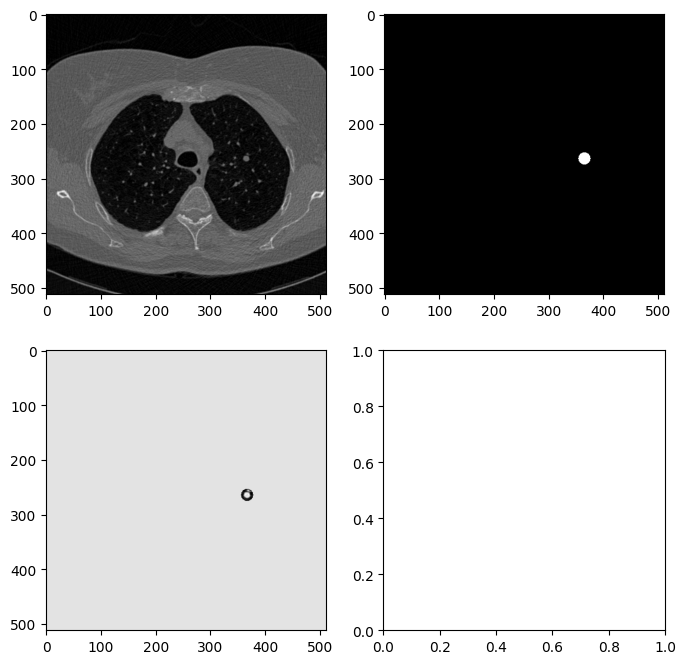

image 1


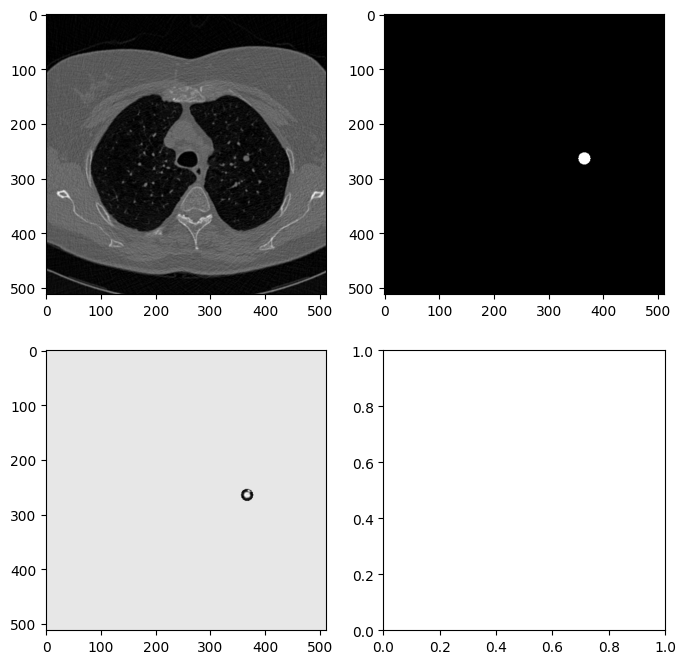

image 2


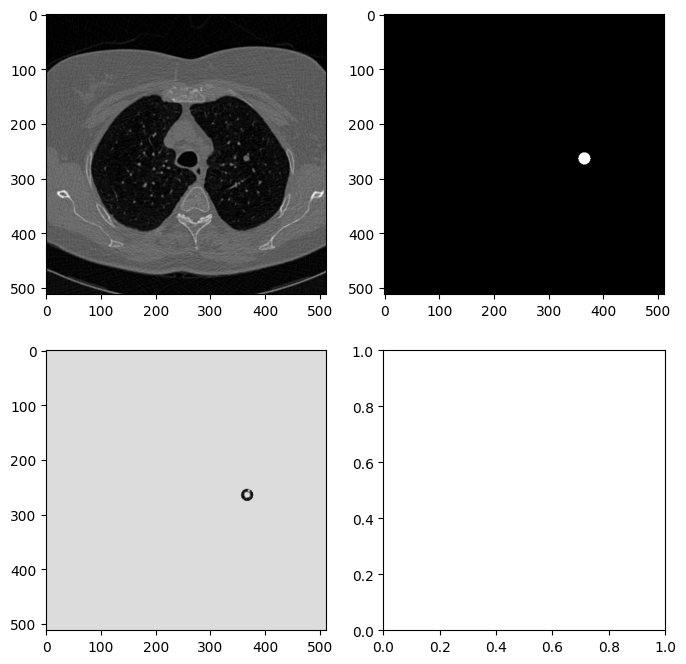

In [16]:
import matplotlib.pyplot as plt

imgs = np.load("./"+'images_0014_0098.npy')
masks = np.load("./"+'masks_0014_0098.npy')
print(masks.shape)
for i in range(len(imgs)):
    print("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()
    # raw_input("hit enter to cont : ")

In [18]:
# temp.py

import SimpleITK as sitk
import os
import numpy as np

file_name = "./subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"
itk_img = sitk.ReadImage(file_name)
img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
# center = np.array([node_x, node_y, node_z])   # nodule center
origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
# v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering

num_z, height, width = img_array.shape

[123. 332.  84.]
[-104.4419748    57.83942814 -124.3083633 ]
